# Demo for nonlinear inverse design of kirigami patterns

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from kirigami.structure import *
from kirigami.utils import *
import scipy.optimize as scopt
import time

## Define an objective function based on circularity

In [16]:
def boundary_residual_circle(interior_offsets_vector):
    """
    Objective function for optimizing kirigami pattern to achieve circular boundary contraction.
    
    This function evaluates how well the contracted kirigami pattern approximates a circle
    by measuring deviations from uniform radial distances to the boundary center.
    
    Parameters
    ----------
    interior_offsets_vector : np.ndarray, shape (width*height,)
        Flattened array of interior offset parameters for the kirigami pattern.
        Will be reshaped to (height, width) for the linear inverse design.
    
    Returns
    -------
    residuals : np.ndarray, shape (len(reduced_dual_bound_inds),)
        Residual errors representing deviations from perfect circularity.
        Each element is (distance_from_center - mean_distance) for a boundary point.
        A perfect circle would give zero residuals.
    
    Global Variables Used
    ---------------------
    width : int
        Number of linkage columns in the kirigami pattern (8)
    height : int  
        Number of linkage rows in the kirigami pattern (8)
    structure : MatrixStructure
        Kirigami structure object for layout computation
    boundary_points_vector : np.ndarray, shape (N, 2)
        Concatenated boundary point coordinates
    corners : np.ndarray, shape (4, 2)
        Corner coordinates of the structure
    boundary_offsets : list of lists
        Boundary offset parameters for each edge
    reduced_dual_bound_inds : list, length 36
        Indices of dual boundary nodes used for circularity assessment
        
    Notes
    -----
    The function:
    1. Reshapes the input vector to (height, width) offset matrix
    2. Performs linear inverse design with the given offsets
    3. Computes the layout at φ=0 (contracted state)
    4. Extracts boundary points and calculates distances from centroid
    5. Returns deviations from mean distance as circularity measure
    
    Alternative circularity measure (commented out) uses isoperimetric ratio:
    (perimeter²)/(4π*area) - 1, where 1 indicates perfect circularity.
    """
    
    global width 
    global height 
    global target_phi 
    global structure
    global boundary_points
    global corners
    global boundary_offsets
    global dual_bound_inds
    global reduced_dual_bound_inds
    global boundary_points_vector
    
    # Reshape flattened offsets to 2D grid: (width*height,) -> (height, width)
    interior_offsets = np.reshape(interior_offsets_vector, (height, width))
    
    # update the pattern using the linear inverse design method with the input offset
    structure.linear_inverse_design(boundary_points_vector, corners, interior_offsets, boundary_offsets)
    structure.make_hinge_contact_points()

    # get the second contracted state
    deployed_points, deployed_hinge_contact_points = structure.layout(phi=0.0) 
    
    # assess the circularity using sum( (r-r_mean)^2 )
    distance_from_center = np.sqrt(
        np.square(
            np.array(deployed_points[reduced_dual_bound_inds,0]-np.mean(deployed_points[reduced_dual_bound_inds,0]))
            ) + 
        np.square(
                np.array(deployed_points[reduced_dual_bound_inds,1]-np.mean(deployed_points[reduced_dual_bound_inds,1]))
            )
        )
    residuals = distance_from_center - np.mean(distance_from_center)
    
    # (Alternative way) assess the circularity using (L^2/(4*pi*A) - 1)^2
    # reduced_dual_bound_inds_shifted = reduced_dual_bound_inds[1:]
    # reduced_dual_bound_inds_shifted.append(reduced_dual_bound_inds[0])
    # edgelengths = np.sqrt(np.square(np.array(deployed_points[reduced_dual_bound_inds,0]-deployed_points[reduced_dual_bound_inds_shifted,0])) + np.square(np.array(deployed_points[reduced_dual_bound_inds,1]-deployed_points[reduced_dual_bound_inds_shifted,1])))
    # L = np.sum(edgelengths)
    # pgon = geom.Polygon(zip(deployed_points[reduced_dual_bound_inds,0], deployed_points[reduced_dual_bound_inds,1]))
    # A = pgon.area
    # residuals = L**2/(4*np.pi*A) - 1
    
    return residuals



## Solve for an optimized pattern that gives a square-to-circle transformation

Optimization starts...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5754e+00                                    1.21e+00    
       1              2         4.9565e+00      3.62e+00       9.59e-01       6.60e-01    
       2              3         1.4638e+00      3.49e+00       1.91e+00       2.32e-01    
       3              4         1.0247e+00      4.39e-01       1.59e+00       5.05e-01    
       4              5         8.0473e-01      2.20e-01       2.13e-01       1.61e-01    
       5              7         4.7916e-01      3.26e-01       8.49e-01       4.14e-02    
       6              9         4.2753e-01      5.16e-02       3.82e-01       2.69e-02    
       7             10         3.8394e-01      4.36e-02       8.11e-01       1.16e-01    
       8             11         3.7700e-01      6.94e-03       7.40e-02       9.80e-02    
       9             12         3.7366e-01      3.34e-03       2.30

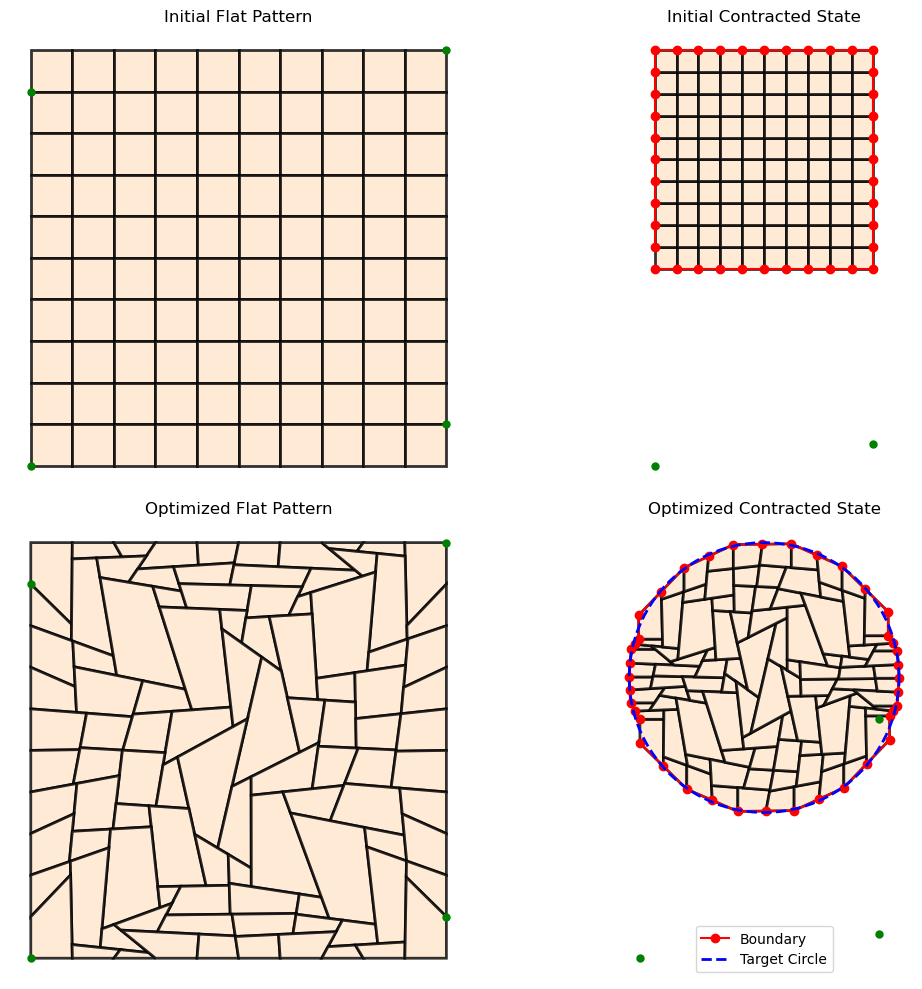

In [ ]:
# set the pattern size
width = 10
height = 10

# create a square kirigami structure and get the required information for the optimization
structure = MatrixStructure(num_linkage_rows=height, num_linkage_cols=width)
bound_linkage_inds = [structure.get_boundary_linkages(i) for i in range(4)]
bound_directions = np.array([[-1.0, 0.0], [0.0, -1.0], [1.0, 0.0], [0.0, 1.0]])
boundary_points = []
corners = []
for i, bound in enumerate(bound_linkage_inds):
    local_boundary_points = []
    for j, linkage_ind in enumerate(bound):
        p = structure.is_linkage_parallel_to_boundary(linkage_ind[0], linkage_ind[1], i)
        if j == 0:
            corner = np.array([linkage_ind[1], -linkage_ind[0]]) + bound_directions[i]
            if not p:
                corner += bound_directions[(i-1)%4]
            corners.append(corner)
        if not p:
            point = np.array([linkage_ind[1], -linkage_ind[0]]) + bound_directions[i]
            local_boundary_points.append(point)
    boundary_points.append(np.vstack(local_boundary_points))
corners = np.vstack(corners)
boundary_offsets = [[0.0]*height, [0.0]*width, [0.0]*height, [0.0]*width]
boundary_points_vector = np.vstack(boundary_points)

# also get the reconfigured boundary node indices for optimizing the second contracted shape
structure.linear_inverse_design(boundary_points_vector, corners, np.reshape(np.zeros(width*height), (height, width)), boundary_offsets)
structure.make_hinge_contact_points()
deployed_points, deployed_hinge_contact_points = structure.layout(phi=0.0) 
dual_bound_inds = []
for bound_ind in range(4):
    dual_bound_inds.extend(structure.get_dual_boundary_node_inds(bound_ind))
reduced_dual_bound_inds = []
for i, ind in enumerate(dual_bound_inds):    
    next_i = (i+1) % len(dual_bound_inds)    
    next_ind = dual_bound_inds[next_i]    
    if norm(deployed_points[ind] - deployed_points[next_ind]) > 1e-10:
        reduced_dual_bound_inds.append(ind)

print("Optimization starts...")
start = time.time()
result = scopt.least_squares(boundary_residual_circle, np.zeros(width*height),
                             bounds=(-np.ones(width*height) + 0.2,np.inf),
                             xtol = 1e-6, 
                             ftol=1e-6, 
                             gtol=1e-6, 
                             max_nfev=300, 
                             verbose=2)
end = time.time()
print("Finished.")
print('Time taken = ' + str(end - start) + ' seconds')
print('Cost = ' + str(result.cost))

# Plot 3: Optimization results comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Initial flat pattern
structure.linear_inverse_design(boundary_points_vector, corners, np.reshape(np.zeros(width*height), (height, width)), boundary_offsets)
structure.make_hinge_contact_points()
initial_flat, _ = structure.layout(phi=np.pi)
plot_structure(initial_flat, structure.quads, structure.linkages, ax1)
# add corner points for reference
ax1.plot(corners[:,0], corners[:,1], 'go', markersize=5)
ax1.set_title("Initial Flat Pattern")
ax1.set_aspect('equal')

# Initial contracted
initial_contracted, _ = structure.layout(phi=0.0)
plot_structure(initial_contracted, structure.quads, structure.linkages, ax2)
# add corner points for reference
ax2.plot(corners[:,0], corners[:,1], 'go', markersize=5)
ax2.plot(initial_contracted[reduced_dual_bound_inds,0], initial_contracted[reduced_dual_bound_inds,1], 'ro-')
ax2.set_title("Initial Contracted State")
ax2.set_aspect('equal')

# Optimized flat pattern
opt_offsets = np.reshape(result.x, (height, width))
structure.linear_inverse_design(boundary_points_vector, corners, opt_offsets, boundary_offsets)
structure.make_hinge_contact_points()
opt_flat, _ = structure.layout(phi=np.pi)
plot_structure(opt_flat, structure.quads, structure.linkages, ax3)
ax3.plot(corners[:,0], corners[:,1], 'go', markersize=5)
ax3.set_title("Optimized Flat Pattern")
ax3.set_aspect('equal')

# Optimized contracted with circle overlay
opt_contracted, _ = structure.layout(phi=0.0)
plot_structure(opt_contracted, structure.quads, structure.linkages, ax4)
# add corner points for reference
ax4.plot(corners[:,0], corners[:,1], 'go', markersize=5)
ax4.plot(opt_contracted[reduced_dual_bound_inds,0], opt_contracted[reduced_dual_bound_inds,1], 'ro-', label='Boundary')
# Add target circle for comparison
center = np.mean(opt_contracted[reduced_dual_bound_inds], axis=0)
radius = np.mean(np.sqrt(np.sum((opt_contracted[reduced_dual_bound_inds] - center)**2, axis=1)))
theta = np.linspace(0, 2*np.pi, 100)
ax4.plot(center[0] + radius*np.cos(theta), center[1] + radius*np.sin(theta), 'b--', linewidth=2, label='Target Circle')
ax4.set_title("Optimized Contracted State")
ax4.set_aspect('equal')
ax4.legend()

plt.tight_layout()
plt.show()

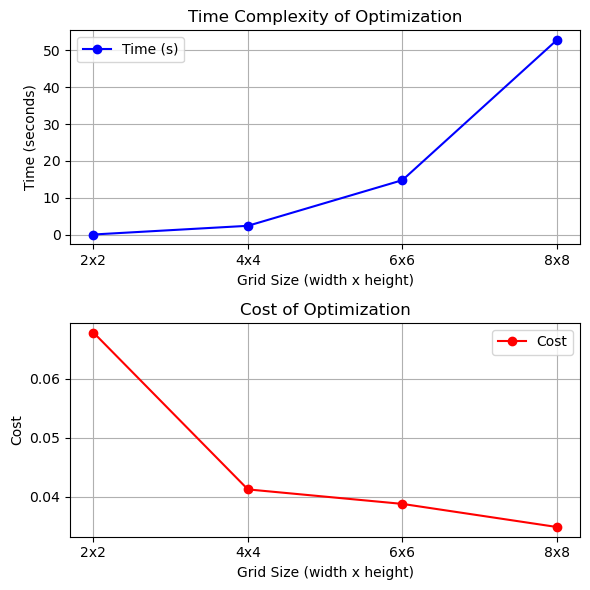

In [18]:
grid_sie = [2, 4, 6, 8]
times = [0.08072757720947266, 2.4358105659484863, 14.793537616729736, 52.73304080963135]
costs = [0.067798362921027, 0.041271954010370974, 0.038821522186830444, 0.03491407870806919]


# I want to have two subplots: one for time and one for cost
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6, 6))
# Plot time vs grid size
ax1.plot(grid_sie, times, marker='o', linestyle='-', color='b', label='Time (s)')
ax1.set_xlabel('Grid Size (width x height)')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Time Complexity of Optimization')
ax1.grid(True)
ax1.set_xticks(grid_sie)
ax1.set_xticklabels([f'{w}x{h}' for w, h in zip(grid_sie, grid_sie)])
ax1.legend() 
# Plot cost vs grid size
ax2.plot(grid_sie, costs, marker='o', linestyle='-', color='r', label='Cost')
ax2.set_xlabel('Grid Size (width x height)')
ax2.set_ylabel('Cost')
ax2.set_title('Cost of Optimization')
ax2.grid(True)
ax2.set_xticks(grid_sie)
ax2.set_xticklabels([f'{w}x{h}' for w, h in zip(grid_sie, grid_sie)])
ax2.legend()
plt.tight_layout()
plt.show()


## Plot the optimized pattern

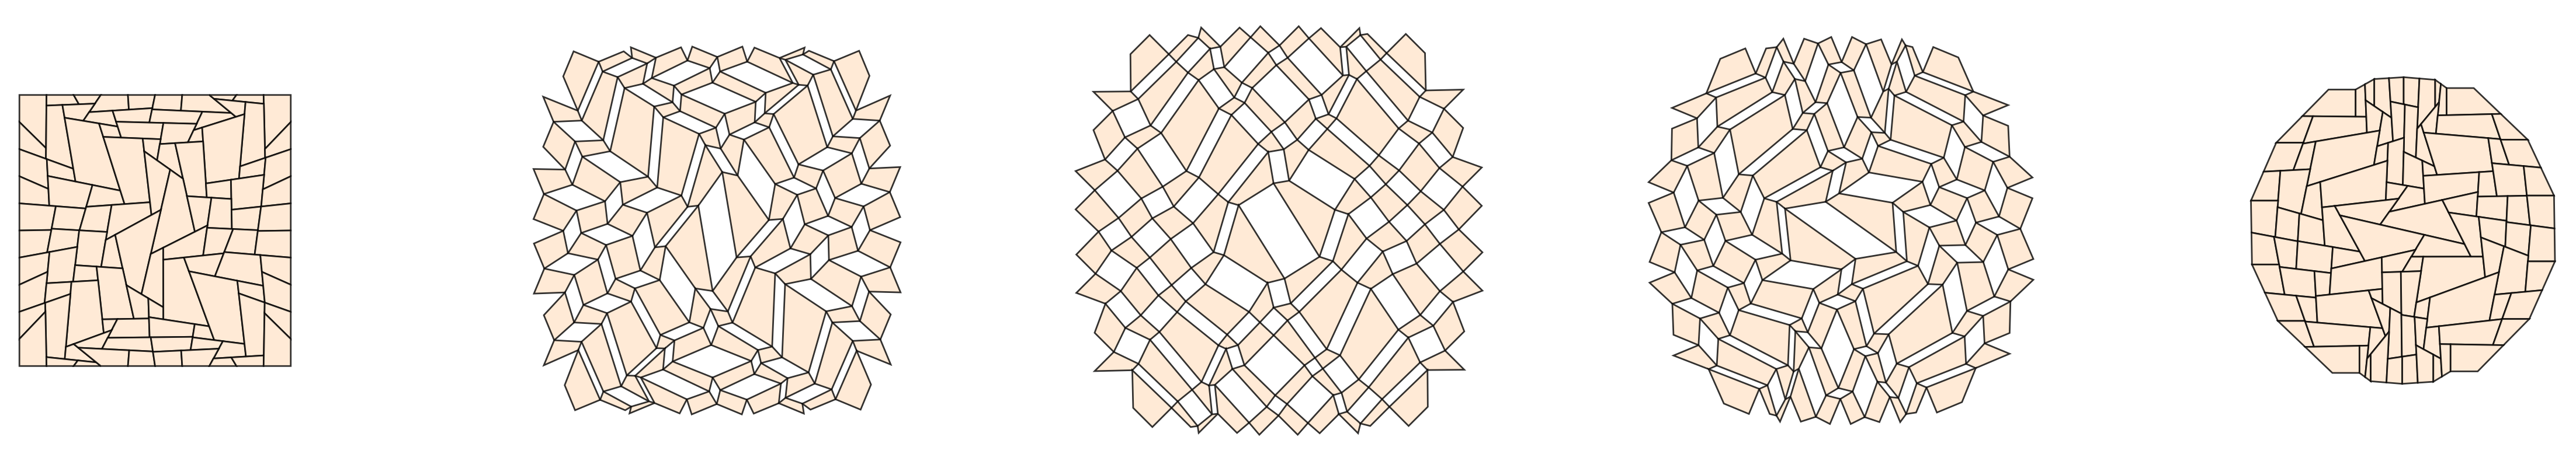

In [19]:
interior_offsets = np.reshape(result.x, (height,width)) # optimal offsets
structure.linear_inverse_design(np.vstack(boundary_points), corners, interior_offsets, boundary_offsets)
structure.assign_node_layers()
structure.assign_quad_genders()
structure.make_hinge_contact_points()

num_frames = 5
phis = np.linspace(np.pi, 0, num_frames)

panel_size = 10
fig, axs = plt.subplots(1, num_frames, figsize=(1.2*panel_size*num_frames, panel_size), sharey=True)

for ax_ind, phi in enumerate(phis):
    
    deployed_points, deployed_hinge_contact_points = structure.layout(phi)
    deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - phi)/2.0)
    
    deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
    deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2
    
    plot_structure(deployed_points, structure.quads, structure.linkages, axs[ax_ind])
    # add corner points for reference
    # axs[ax_ind].plot(corners[:,0], corners[:,1], 'ro', markersize=5)
    axs[ax_ind].set_aspect('equal')
    
#     write_obj('Example_square-to-circle_' + str(ax_ind) + '.obj', deployed_points, structure.quads)